In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import hashlib
import json
from itertools import combinations

In [2]:
# plotting function from before
def plot_nodes_and_edges(nodes,edges,pos=None,padding=1):
    plt.figure(figsize=(6, 6))
    G = nx.Graph()
    for node, domain in nodes.items():
        G.add_node(node, domain=domain)
    G.add_edges_from(edges)
    if(pos is None):
        pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='white',edgecolors='black', linewidths=2)
    nx.draw_networkx_edges(G, pos)
    labels = {node: f"{node}\n\n{G.nodes[node]['domain']}" for node in G.nodes()}
    label_pos = {node: (x+0.01, y - 0.15) for (node, (x, y)) in pos.items()}
    nx.draw_networkx_labels(G, label_pos, labels, font_size=14)   
    x_values, y_values = zip(*pos.values())
    plt.xlim(min(x_values) - padding, max(x_values) + padding)
    plt.ylim(min(y_values) - padding, max(y_values) + padding)
    plt.show()
    return pos # return the position so that we can reuse it for the next plot.

## 1.3 Heuristic search algorithms
In the previous section we found an algorithm to solve a distributed constraint satisfaction problem, but it was very expensive. Hyper-resolution works, but it generates a huge number of "nogoods". Here we look at some alternatives based on heuristics.

One *slightly centralised* option is to do a recursive search of values, backtracking when you find one that can't work:

In [3]:
def recursive_solve(index,nodes,edges,old_values):    
    if(index==len(nodes)):
        return old_values # success!!!
    
    this_node_name = list(nodes.keys())[index]
    for option in nodes[this_node_name]:
        invalid = False
        for edge in edges:
            if(edge[0]==this_node_name or edge[1]==this_node_name):
                other_node_name = edge[1] if edge[0]==this_node_name else edge[0]
                if other_node_name in old_values:
                    if old_values[other_node_name]==option:
                        invalid = True
                        break
                        
        if not invalid:
            new_values = old_values.copy()
            new_values[this_node_name]=option
            future_solve = recursive_solve(index+1,nodes,edges,new_values)
            if(not future_solve is None):
                return future_solve
            
    return None # if we get to here no values have worked

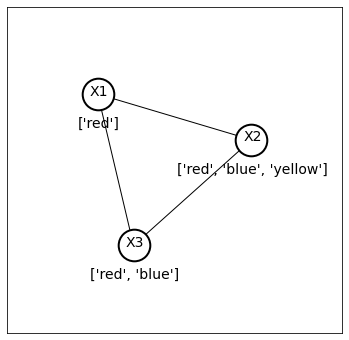

{'X1': 'red', 'X2': 'yellow', 'X3': 'blue'}


In [4]:
nodes1 = {
    "X1":["red"],
    "X2":["red","blue","yellow"],
    "X3":["red","blue"]
}
edges1 = [("X1","X2"),("X1","X3"),("X2","X3")]
    
_ = plot_nodes_and_edges(nodes1,edges1)
print(recursive_solve(0,nodes1,edges1,{}))

This should work - showing $X1=\text{red}$, $X2=\text{yellow}$ and $X3=\text{blue}$

Not only does this work in simple cases, but is complete and identifies when there isn't a solution:

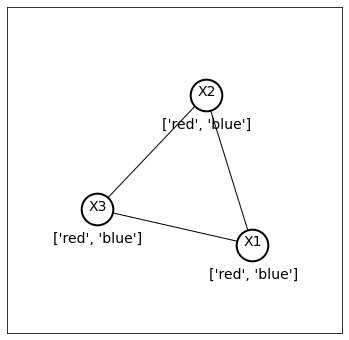

None


In [5]:
nodes2 = {
    "X1":["red","blue"],
    "X2":["red","blue"],
    "X3":["red","blue"]
}
edges2 = [("X1","X2"),("X1","X3"),("X2","X3")]
    
_ = plot_nodes_and_edges(nodes2,edges2)
print(recursive_solve(0,nodes2,edges2,{}))

And finds an answer when there are multiple options:

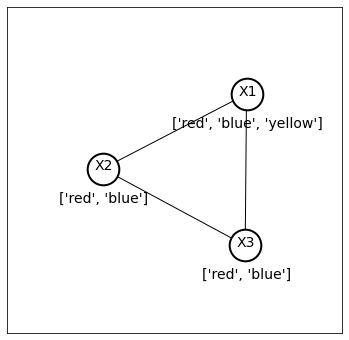

{'X1': 'yellow', 'X2': 'red', 'X3': 'blue'}


In [6]:
nodes3 = {
    "X1":["red","blue","yellow"],
    "X2":["red","blue"],
    "X3":["red","blue"]
}
edges3 = [("X1","X2"),("X1","X3"),("X2","X3")]
    
_ = plot_nodes_and_edges(nodes3,edges3)
print(recursive_solve(0,nodes3,edges3,{}))

But, this isn't a distributed algorithm. Each node is just operating in sequence, rather than in parallel. A distributed alternative is that each node just selects in turn a value that is consistent with it's neighbours:

In [7]:
def simple_distributed_algorithm(nodes, edges):
    values = dict(zip(nodes.keys(),[domain[0] for domain in nodes.values()]))
    for epoch in range(100):
        print("values:", values)
        solution_found = True
        for this_node_name in nodes.keys():            
            # check if it is currently consistent with neighbours
            node_is_currently_consistent = True
            for edge in edges:
                if(edge[0]==this_node_name or edge[1]==this_node_name):
                    other_node_name = edge[1] if edge[0]==this_node_name else edge[0]
                    if(values[this_node_name]==values[other_node_name]):
                        node_is_currently_consistent = False
                        solution_found = False
            
            # if it isn't, try to find a new value
            if not node_is_currently_consistent:
                print(this_node_name,"is not consistent")
                any_consistent = False
                for option in nodes[this_node_name]:
                    all_consistent = True
                    for edge in edges:
                        if(edge[0]==this_node_name or edge[1]==this_node_name):
                            other_node_name = edge[1] if edge[0]==this_node_name else edge[0]
                            if(option==values[other_node_name]):
                                all_consistent = False
                                break
                    
                    if all_consistent:
                        print(this_node_name,"found a new value:",option)
                        values[this_node_name]=option
                        any_consistent = True
                        break
                
                if not any_consistent:
                    # if you didn't find a value, end here.
                    print("solution not found")
                    return None
            
        if solution_found:
            print("solution found!")
            return values
    
    print("maximum iterations reached, quitting")
    return None

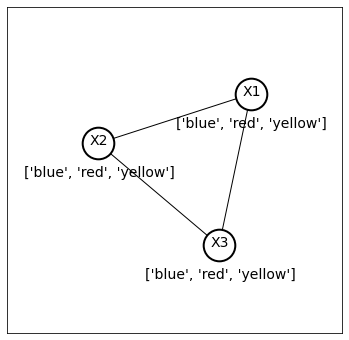

values: {'X1': 'blue', 'X2': 'blue', 'X3': 'blue'}
X1 is not consistent
X1 found a new value: red
X2 is not consistent
X2 found a new value: yellow
values: {'X1': 'red', 'X2': 'yellow', 'X3': 'blue'}
solution found!


In [8]:
nodes4 = {
    "X1":["blue","red","yellow"],
    "X2":["blue","red","yellow"],
    "X3":["blue","red","yellow"]
}
edges4 = [("X1","X2"),("X1","X3"),("X2","X3")]
    
_ = plot_nodes_and_edges(nodes4,edges4)
solution = simple_distributed_algorithm(nodes4,edges4)

This algorithm works sometimes, but is not complete. In certain cases it will say there is no answer, even when there is one:

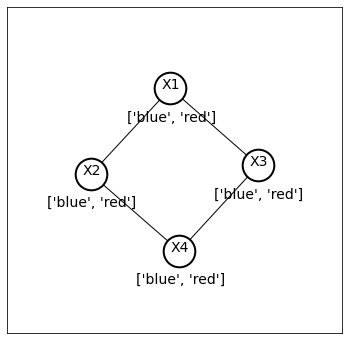

values: {'X1': 'blue', 'X2': 'blue', 'X3': 'blue', 'X4': 'blue'}
X1 is not consistent
X1 found a new value: red
X2 is not consistent
solution not found


In [9]:
nodes5 = {
    "X1":["blue","red"],
    "X2":["blue","red"],
    "X3":["blue","red"],
    "X4":["blue","red"]
}
edges5 = [("X1","X2"),("X1","X3"),("X2","X4"),("X3","X4")]
    
_ = plot_nodes_and_edges(nodes5,edges5)
solution  = simple_distributed_algorithm(nodes5,edges5)

This problem has a solution (alternating between blue and red), but it doesn't get found. The other problem is that with communication delays the algorithm can get stuck in a cycle. Imagine I am red, and switch to blue. But then my neighbour was also red and switches to blue as well. We can end up looping forever back and forth.

The asychronous-backtracking algorithm is the most important heuristic method in solving distributed constraint problems, and is somewhat a mixture of these two approaches. It is discussed in the next notebook.